# import libraries

In [1059]:
import numpy as np 
import networkx as nx 
from random import sample
import matplotlib.pyplot as plt 
import random
import itertools
import pandas as pd

# define a useful function for organizing data 

In [1823]:
def organize(x,e,l):
    for index,item in enumerate(x):
        x[index]=np.append(item,([item[-1]]*(l-len(item))))
    return np.stack(x,axis=0) 

# define the main class 

In [1938]:
class seir():

    def __init__(self, n ,beta, sigma, gamma,k,v=0,q=0,q_days=6,p_q=0.1,seed=42):
        self.n = n 
        self. beta = beta 
        self.sigma = sigma 
        self.gamma = gamma 
        self.k  = k 
        self.p = k/n
        self.v=v
        self.q_days = q_days 
        self.p_q = p_q*self.beta
        self.q = q
        self.G = nx.fast_gnp_random_graph(self.n, self.p, seed=seed)
    
    def initiate(self,s0 = 0.999,i0 = 0.001,seed = 42):
        if s0+i0>1:
            raise ValueError('The initial condition is not correct: i0+s0>1')
        else :
            random.seed(seed)
            random_nodes = sample(list(self.G.nodes()),self.n)
            s0_l, r0_l, i0_l = np.split(random_nodes,[int(s0*self.n), int((1-i0)*self.n)])

            self.x0 = s0_l
            self.y0 = i0_l
            self.z0 = r0_l
            self.e0 = []

            self.x = list(self.x0)
            self.y = list(self.y0)
            self.e = list(self.e0)
            self.z = list(self.z0)
            self.q_list=[]


            self.attrs={}
            for x in s0_l:
                self.attrs[x]='s'
            for y in i0_l:
                self.attrs[y]='i'
            for z in r0_l:
                self.attrs[z]='r'
            
            e_times={}
            for node in range(self.n):
                e_times[node] = 0 
            
            transmision_p = {}
            for node in range(self.n):
                transmision_p[node] = self.beta 


            nx.set_node_attributes(self.G,self.attrs,"now")
            nx.set_node_attributes(self.G,self.attrs,'tomorrow')
            nx.set_node_attributes(self.G,e_times,'e_time')
            nx.set_node_attributes(self.G,e_times,'q_time')
            nx.set_node_attributes(self.G,transmision_p,'beta')
            nx.set_node_attributes(self.G,e_times,'q_condition')

            

            

        

    def SE(self):
        self.new_e=[]
        self.new_q=[]
        #print(f'SE: {len(x)}')
        for node in self.y: 

            random = np.random.rand(len(list(self.G.neighbors(node))))
            affected = list(self.G.neighbors(node))
        
            for index,number in enumerate(random):

                if number<self.q and self.G.nodes[affected[index]]['q_condition']==0 and self.G.nodes[affected[index]]['now']=='s': #and self.G.nodes[affected[index]]['tomorrow']=='s':
                    self.q_list.append(affected[index])
                    self.G.nodes[affected[index]]['q_condition']=1
                    self.new_q.append(affected[index])
                    
                if np.random.rand()<self.G.nodes[node]['beta'] and self.G.nodes[affected[index]]['now']=='s' and self.G.nodes[affected[index]]['tomorrow']=='s':
                    #print('y')
                    self.new_e.append(affected[index])
                    self.G.nodes[affected[index]]['tomorrow']='e'

                


                
                
    def EI(self):
        self.new_i=[]
        #random = np.random.rand(len(self.e))
        #for index,number in enumerate(random):
        for node in self.e:
            self.G.nodes[node]['e_time']+=1
            if self.G.nodes[node]['e_time']==self.sigma:
                self.new_i.append(node)
                self.G.nodes[node]['tomorrow']='i'

    def IR(self):
        self.cured=[]
        random = np.random.rand(len(self.y))
        for index,number in enumerate(random):
            if number<self.gamma:
                self.G.nodes[self.y[index]]['tomorrow']='r'
                self.cured.append(self.y[index])
                self.R[self.t]+=1

    def vaccine(self):
        self.vacc=[]
        random = np.random.rand(len(self.x))
        for index,number in enumerate(random):
            if number<self.v and self.G.nodes[self.x[index]]['now']=='s' and self.G.nodes[self.x[index]]['tomorrow']=='s':
                self.vacc.append(self.x[index])
                self.G.nodes[self.x[index]]['tomorrow']='r'
                self.vac_list[self.t]+=1


    def update_vaccine(self):
        for item in self.vacc:
            self.G.nodes[item]['now'] = self.G.nodes[item]['tomorrow']
            self.x.remove(item)

        #self.R[self.t]+=len(self.vacc)

    
    
    def update_quarantine(self):
        for node in self.new_q:
            self.G.nodes[node]['beta']=self.p_q
            #self.quar_hist.append(node)
        for node in self.q_list:
            #print(node)
            self.G.nodes[node]['q_time']+=1
            if self.G.nodes[node]['q_time']==self.q_days:
                self.q_list.remove(node)
                self.G.nodes[node]['beta'] = self.beta
                self.G.nodes[node]['q_condition'] = 0
                self.G.nodes[node]['q_time'] = 0


    
    
    def update(self):
        for item in self.new_e:
            self.G.nodes[item]['now']=self.G.nodes[item]['tomorrow']

        for item in self.new_i:
            self.G.nodes[item]['now']=self.G.nodes[item]['tomorrow']
     
        for item in self.cured:
            self.G.nodes[item]['now']=self.G.nodes[item]['tomorrow']
   
        
        for item in self.cured:
            self.y.remove(item)
        self.y.extend(self.new_i)

        for item in self.new_i:
            self.e.remove(item)
        self.e.extend(self.new_e)

        for item in self.new_e:
            self.x.remove(item)
        
        
        self.I[self.t]=len(self.y)
        
        self.E[self.t]=len(self.e)
        self.R[self.t]=self.R[self.t-1]+self.R[self.t]
        self.S[self.t]=len(self.x)#self.n-self.I[self.t]-self.R[self.t]-self.E[self.t]

        


    
    
    def forward(self):
        self.SE()
        self.EI()
        self.IR()

        if self.v!=0:
            self.vaccine()
            self.update_vaccine()
        
        if self.q!=0:
            self.update_quarantine()
        
        self.update()


    
    def total(self):
        return(self.S+self.E+self.I+self.R)
    
    
    def run(self,time=100,ends = -1):
        
        self.S=np.zeros(time)
        self.E=np.zeros(time)
        self.I=np.zeros(time) 
        self.R=np.zeros(time)
        self.vac_list=np.zeros(time)
        self.quar_hist=[]

        self.S[0] = len(self.x0)
        self.E[0] = len(self.e0)
        self.I[0] = len(self.y0)
        self.R[0] = len(self.z0)
        self.vac_list[0] = 0
        #self.quar_hist[0]=0
        
        
        self.t=1
        
        while self.t<time:
            
            self.forward()
            if (len(self.y)==0 and len(self.e)==0):
                self.S[self.t+1:]=self.S[self.t]
                self.R[self.t+1:]=self.R[self.t]
                break
                
            self.t+=1
            if self.t==time and len(self.y)!=0:
                time+=time
                self.S=np.append(self.S,np.zeros(time))
                self.E=np.append(self.E,np.zeros(time))
                self.I=np.append(self.I,np.zeros(time))
                self.R=np.append(self.R,np.zeros(time))
        



In [1276]:
def run_for_ensemble(beta,en_number=500,n=1000,sigma = 2 ,gamma= 0.25 ,avg = 6 , v=0 , q=0, q_days= 6):
    meta_S,meta_I,meta_E,meta_R,R_inf=[],[],[],[],[]
    vac_num = []
    for i in range(en_number):
        print(f'\r{i+1} from {en_number}',end='')
        er = seir(n=n,beta=beta,sigma=sigma,gamma=gamma,v=v,k=avg,q=q,q_days=q_days,seed = np.random.randint(100))
        er.initiate(seed = np.random.randint(100))
        er.run(100)

        meta_S.append(er.S)
        meta_E.append(er.E)
        meta_I.append(er.I)
        meta_R.append(er.R)
        R_inf.append(er.R[-1])
        vac_num.append(er.vac_list)

    return meta_S,meta_E,meta_I,meta_R,vac_num,R_inf,er


In [1127]:
def phase_func(num=20,en_number=500,n=1000,sigma = 2 ,gamma= 0.25 ,avg = 6 , v=0 , q=0, q_days= 6):
    beta_list = np.linspace(0,1,num)
    phase=[]
    for beta in beta_list:
        R_inf=[]
        for e in range(en_number):
            print(f'\r{beta}:{e+1} from {en_number}',end='')
            er = seir(n=n,beta=beta,sigma=sigma,gamma=gamma,v=v,k=avg,q=q,q_days=q_days,seed = np.random.randint(100))
            er.initiate(seed = np.random.randint(100))
            er.run(100)
            R_inf.append(er.R[-1])
        
        phase.append((np.mean(R_inf),np.std(R_inf)))
    return phase,beta_list



In [1883]:
def hist_diagram(param_list,name,p1,p2):
    dic = {'I':'infecteds','S':'susceptibles', 'E':'exposed','R':'recovered','V':'vacinated'}
    fig,ax=plt.subplots(figsize=(7,5))
    pp = list(itertools.product(p1, p2)) 

    for l,p in enumerate(pp):
        for i in range(param_list[l].shape[1]):
            if not max(param_list[l][:,i]) and i>5:
                break

        x=range(1,param_list[l][:,:i].shape[1]+1)
        y=np.mean(param_list[l][:,:i],axis=0)
        error=np.std(param_list[l][:,:i],axis=0)
    
        ax.plot(x,y,label=f'p1 ={p[0]:0.2f} , p2 ={p[1]:0.2f} ')
        ax.fill_between(x, y-error, y+error,alpha=0.3)

    ax.set_xlabel('time')
    ax.set_ylabel(f'{name}(t)')
    ax.set_title(f'average number of {dic[name]} versus time')
    ax.legend()
    #plt.savefig('I for p=%0.2f.pdf'%p,bbox_inches='tight') 


In [1961]:
%%time
n = 1000

beta_list = np.arange(0,1.05,0.05)
#beta_list=[0.9]
sigma = 2 
gamma = 0.25
g = 6 
p1 = [0]
p2=[0]
#p1 = [0,0.05,0.07,0.1,0.15,0.2,0.25]
p2 = [0,0.1,0.3,0.5,0.7,0.9,0.1]


pp = list(itertools.product(p1, p2,beta_list)) 
ensembles = 200

mega_S,mega_E,mega_I,mega_R,R_inf_mega,vac_num_mega=[],[],[],[],[],[]

parameters_dict={1:('S','e_S'),2:('E','e_E'),3:('I','e_I'),4:('R','e_R'),5:('vac_num','e_vac')}
columns = ['S','e_S','E','e_E','I','e_I','R','e_R','vac_num']

#df2 = pd.DataFrame(columns=pp)
#df2.columns = ['{}_{}'.format(x[0], x[1]) for x in df2.columns]

counter=0
for p11,p22,beta in pp:
    counter+=1 
    print(f'\n{counter} from {len(pp)}')
    #meta_S,meta_E,meta_I,meta_R,vac_num,R_inf,er = run_for_ensemble(beta=beta,v=p11,q=p22,en_number=ensembles)
    
    META = run_for_ensemble(beta=beta,v=p11,q=p22,en_number=ensembles)
    mm=max([len(i) for i in META[1]])
    df = pd.DataFrame(columns=columns)
    
    for i in range(len(META)-2):

        parameter = organize(META[i],ensembles,mm)
        y = np.mean(parameter,axis=0)
        error = np.std(parameter,axis=0)
        df[parameters_dict[i+1][0]] = y 
        df[parameters_dict[i+1][1]] = error 
    
    
    df.to_csv(f'csv/p1={p11:.2f},p2={p22:.2f},beta={beta:.2f}.csv')
    
 
    #df2['{}_{}'.format(p11, p22)] = META[-2]

    
#df2.to_csv(f'csv/R_inf.csv')





    
    

'''
    mega_S.append(meta_S)
    mega_E.append(meta_E)
    mega_I.append(meta_I)
    mega_R.append(meta_R)
    R_inf_mega.append(R_inf)
    vac_num_mega.append(vac_num)

#meta_S2,meta_E2,meta_I2,meta_R2,R_inf2,vac_num2 = run_for_ensemble(beta=beta,v=p1,q=p2[1],en_number=ensembles)
#meta_S2,meta_E2,meta_I2,meta_R2,R_inf2 = run_for_ensemble(beta=beta,q=0.1,en_number=ensembles)
#er = seir(n,beta= beta,sigma = sigma,gamma= gamma,k = g,v=0 , q=0.3, q_days= 6, seed = np.random.randint(100))
#er.initiate(seed = np.random.randint(100))
#er.run(100)
'''



1 from 147
200 from 200
2 from 147
200 from 200
3 from 147
200 from 200
4 from 147
200 from 200
5 from 147
200 from 200
6 from 147
200 from 200
7 from 147
200 from 200
8 from 147
200 from 200
9 from 147
200 from 200
10 from 147
200 from 200
11 from 147
200 from 200
12 from 147
200 from 200
13 from 147
200 from 200
14 from 147
200 from 200
15 from 147
200 from 200
16 from 147
200 from 200
17 from 147
200 from 200
18 from 147
200 from 200
19 from 147
200 from 200
20 from 147
200 from 200
21 from 147
200 from 200
22 from 147
200 from 200
23 from 147
200 from 200
24 from 147
200 from 200
25 from 147
200 from 200
26 from 147
200 from 200
27 from 147
200 from 200
28 from 147
200 from 200
29 from 147
200 from 200
30 from 147
200 from 200
31 from 147
200 from 200
32 from 147
200 from 200
33 from 147
200 from 200
34 from 147
200 from 200
35 from 147
200 from 200
36 from 147
200 from 200
37 from 147
200 from 200
38 from 147
200 from 200
39 from 147
200 from 200
40 from 147
200 from 200
41 from 

KeyboardInterrupt: 

In [1954]:
S,I,R,E,V=[],[],[],[],[]
for l,p in enumerate(pp): 
    mm=max([len(i) for i in mega_S[l]])
    S.append(organize(mega_S[l],ensembles,mm))
    I.append(organize(mega_I[l],ensembles,mm))
    R.append(organize(mega_R[l],ensembles,mm))
    E.append(organize(mega_E[l],ensembles,mm))
    V.append(organize(vac_num_mega[l],ensembles,mm))


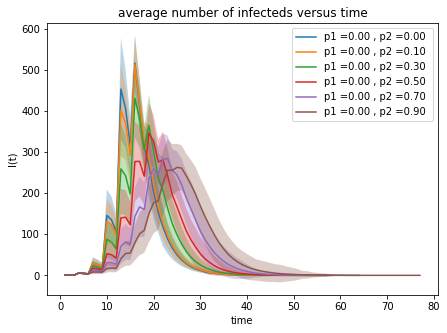

In [1955]:
hist_diagram(I,'I',p1,p2)
plt.show()

# Phase change 

In [966]:
%%time
ensembles = 500
phase,beta_list = phase_func(en_number=ensembles)

1.0:500 from 500Wall time: 16min 28s


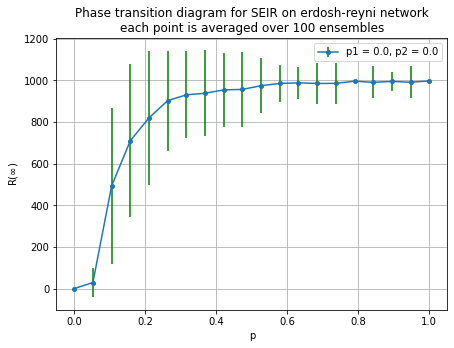

In [985]:
means=[i[0] for i in phase]
error=[i[1] for i in phase]

fig=plt.figure(figsize=(7,5))
plt.errorbar(x=beta_list,y=means,yerr=error,ms=4,fmt='-o',ecolor='g',label=f'p1 = {p1:0.1f}, p2 = {p2:0.1f}')
plt.xlabel('p')
plt.ylabel('R($\infty$)')
plt.title('Phase transition diagram for SEIR on erdosh-reyni network\neach point is averaged over %i ensembles'%ensembles)
plt.grid()
plt.legend()
#plt.savefig('phase transition r=%0.2f.pdf'%r,bbox_inches='tight')